In [1]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset, get_labelencoder_mapping
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
seed = 42
np.random.seed(seed)

created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

clean = True
if clean:
    print("Deleting old augmented")
    os.system(f'rm -rf {path_images_augmented}*')

nb_classes = 3

if nb_classes == 3:
    target_classes = ['v','wmv','v(cy)','other']
elif nb_classes == 9:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','sw','t','other']
elif nb_classes == 6:
    target_classes = ['m','v','bl','c','wmv','v(cy)','other']
elif nb_classes == 21:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','gaasvlieg','grv','k','kever','nl','psylloidea','sp','sst','sw','t','vlieg','weg','wnv','wswl','other']
elif nb_classes == 1:
    target_classes = ['wmv', 'other']

epochs = 100
batch_size = 32
monitor='val_accuracy'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = f'DenseNet121_{nb_classes}classes_{img_dim}'

Deleting old augmented


In [2]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_2019 = pd.DataFrame()
df_2019['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/2019*.jpg"))
df_2019['pname'] = df_2019['x'].apply(lambda p: p.split('/')[-1][:-4])
df_2019['pname'] = df_2019['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_2019['y_text'] = df_2019['x'].apply(lambda x: x.split('/')[-2])
df_2019['y_text'] = df_2019['y_text'].apply(lambda x: 'other' if x not in target_classes else x)

if nb_classes in [1,3]:
    df_2019.drop(df_2019[df_2019.y_text == 'other'].sample(10000, random_state=42).index, axis='index', inplace=True)
else:
    df_2019.drop(df_2019[df_2019.y_text == 'other'].sample(1, random_state=42).index, axis='index', inplace=True)
# df_2019.drop(df_2019[df_2019.y_text == 'other'].index, axis='index', inplace=True)

df_2019['y'] = le.fit_transform(df_2019.y_text)

In [3]:
df_2019.y_text.value_counts()

other    7757
v        4731
wmv      4056
v(cy)    2014
Name: y_text, dtype: int64

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

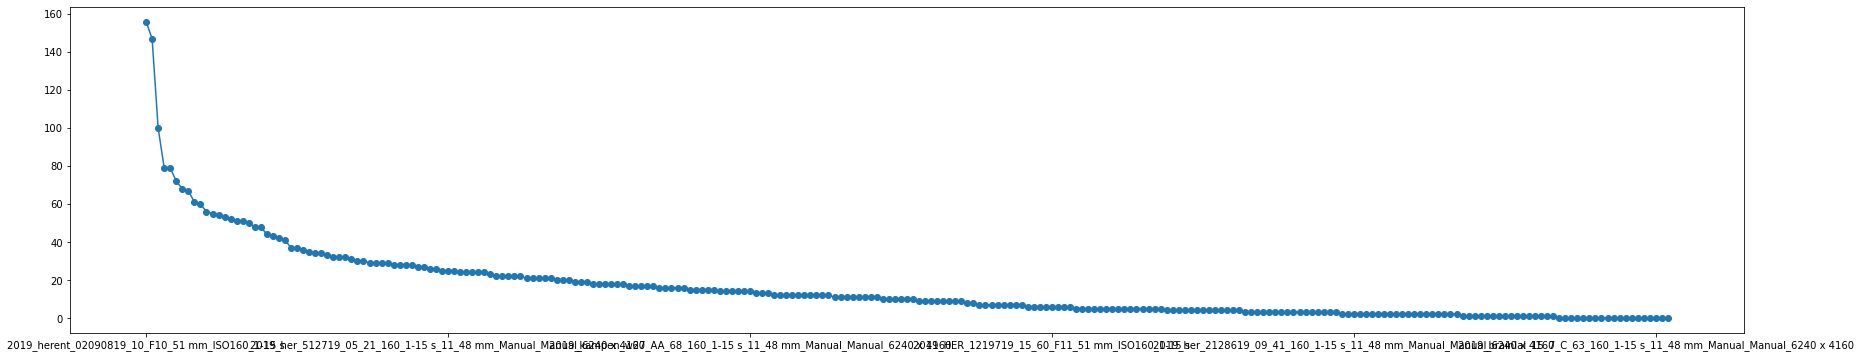

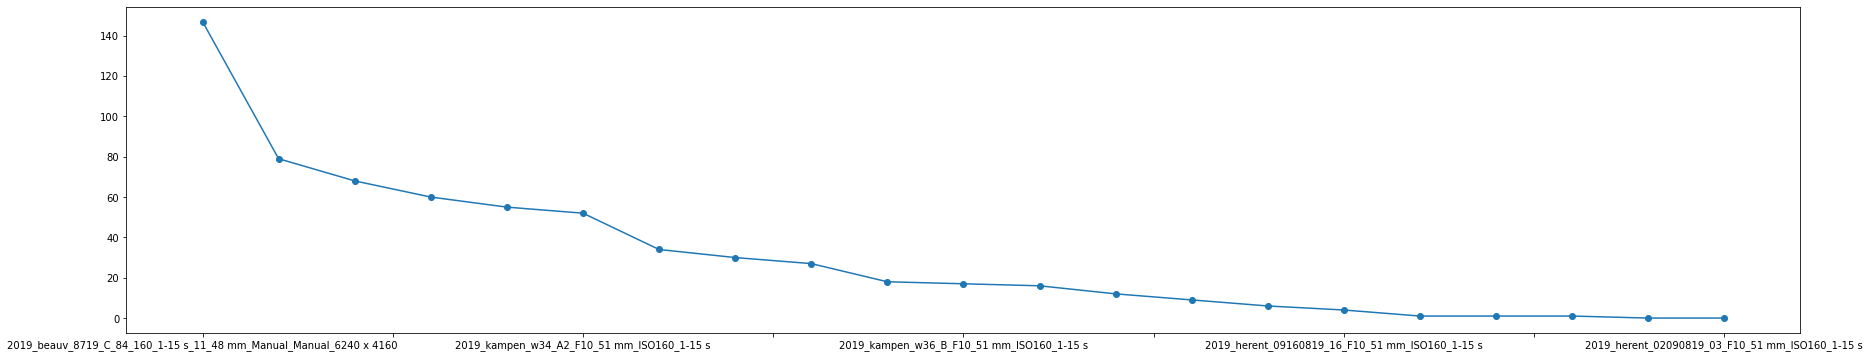

In [4]:
# Sampling some test plates. 2 from first 5, 2 from next five....
target_insect_dict = {}
for i, sub in df_2019.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)
test_plates = []
test_plates.extend(ser.iloc[:5].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[5:10].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[10:15].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[20:].sample(15, random_state=42).index.values.tolist())
test_plates = ser.loc[test_plates].sort_values(ascending=False).index.tolist()
# Plotting
ser.plot(marker='o', figsize=(30,6))
plt.figure()
ser.loc[test_plates].sort_values(ascending=False).plot(marker='o', figsize=(30,6))

In [5]:
X_test = df_2019.x[df_2019.pname.isin(test_plates)]
y_test = df_2019.y[df_2019.pname.isin(test_plates)]
print("Test set class balance")
print(df_2019[df_2019.pname.isin(test_plates) ].y_text.value_counts())

Test set class balance
wmv      637
other    590
v        368
v(cy)    191
Name: y_text, dtype: int64


In [6]:
X_train = df_2019.x[~df_2019.pname.isin(test_plates)]
y_train = df_2019.y[~df_2019.pname.isin(test_plates)]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, shuffle=True)
print("Train/val set class balance")
print(df_2019[~df_2019.pname.isin(test_plates) ].y_text.value_counts())

Train/val set class balance
other    7167
v        4363
wmv      3419
v(cy)    1823
Name: y_text, dtype: int64


In [7]:
# Splitting into train/val/test # Randomly
# X_train, X_test, y_train, y_test = train_test_split(df_2019.x, df_2019.y, test_size=0.2, random_state=seed, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

In [8]:
augment_classes = target_classes#['wmv']#,'v(cy)']
if 'other' in target_classes:
    target_classes.remove('other')

labelmap = get_labelencoder_mapping(le)

augment_trainset(df_train=pd.DataFrame({"X_train": X_train, "y_train": y_train}),  
                 augment_classes=[labelmap[i] for i in augment_classes],
                 aug_imgs_path=path_images_augmented,
                 img_dim=img_dim,
                 nb_batches= 70, 
                 batch_size=100)

df_train before selecting classes: (14256, 2)
df_train after selecting classes: (8134, 2)
 Reading image data and assigning labels...
Normalizing data by dividing by 255.
Creating an ImageDataGenerator.
Creating directories for each class.
Fitting data generator on data.
Expanding dataset by using generator's flow method on data/labels.
using batch_size of 100
Finished augmentation in 70 batches of 100


In [9]:
# Gathering info on augmented X_train data
df_aug = pd.DataFrame()
df_aug['x'] = pd.Series(glob.glob(f"{path_images_augmented}/*/*.jpg")) # path_images_augmented
df_aug['textlabels'] = df_aug['x'].apply(lambda x: x.split('/')[-2])
df_aug['textlabels'] = df_aug['textlabels'].apply(lambda x: 'other' if x not in target_classes else x)
df_aug['y'] = le.transform(df_aug.textlabels)

In [10]:
X_train_aug = X_train.tolist() + df_aug.x.tolist()
y_train_aug = y_train.tolist() + df_aug.y.tolist()

# c = list(zip(X_train_aug, y_train_aug))
# random.shuffle(c)
# X_train_aug, y_train_aug = zip(*c)
# X_train_aug = list(X_train_aug)
# y_train_aug = list(y_train_aug)
X_val = X_val.tolist()
y_val = y_val.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

In [11]:
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)
X_test, y_test = shuffle(X_test, y_test, random_state=seed)

In [12]:
# X_val

In [13]:
print(f"Train:\n{pd.Series(y_train_aug).value_counts()}")
print(f"\nVal:\n{pd.Series(y_val).value_counts()}")
print(f"\nTest:\n{pd.Series(y_test).value_counts()}")

Train:
1    6921
0    6122
3    5374
2    2839
dtype: int64

Val:
0    1045
1     651
3     526
2     294
dtype: int64

Test:
3    637
0    590
1    368
2    191
dtype: int64


In [14]:
assert len(set(X_train_aug).intersection(set(X_val))) == 0, 'wrong'
assert len(set(X_val).intersection(set(X_test))) == 0, 'wrong'

In [15]:
log_dir = f'{created_data_path}/logs/'
top_weights_path = f'{created_data_path}/weights/{modelname}.h5'

callbacks_list = [ModelCheckpoint(monitor =  monitor,
                                  filepath =  top_weights_path,
                                  save_best_only = False,
                                  save_weights_only = False,
                                  verbose = 1),
                  EarlyStopping(monitor =  monitor,
                                patience =  es_patience,
                                verbose = 1),
                  ReduceLROnPlateau(monitor =  monitor,
                                    factor = 0.1,
                                    patience =  rlr_patience,
                                    verbose = 1),
                # CSVLogger(filename =  logfile),
                  TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)]

## TRAINING FROM SCRATCH

In [16]:
base_model = DenseNet121(include_top=False, weights=None, 
                        input_shape=(img_dim,img_dim,3))
# EfficientNetB2
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(nb_classes+1, activation=None)(x)
predictions = Activation('softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# model.summary()

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_aug), y=y_train_aug)
class_weights = {i : weights[i] for i in range(nb_classes+1)}

print(get_labelencoder_mapping(le))
# print(class_weights)
# class_weights[i] = 0.5
# class_weights[1] = 0.5
# class_weights[-2] = 2.0
# class_weights[6] = 2.5
# class_weights = {0: 0.75, 1: 0.75, 2: 0.75, 3: 0.75, 4: 0.75, 
#                  5: 0.75, 6: 0.75, 7: 0.75, 8: 1.5, 9: 2.2}
print(class_weights)

{'other': 0, 'v': 1, 'v(cy)': 2, 'wmv': 3}
{0: 0.8680169879124469, 1: 0.7678081202138419, 2: 1.8717858400845369, 3: 0.9888351321176033}


In [20]:
import math
FH = model.fit(train_generator(X_train_aug, y_train_aug, batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
                         validation_data=valid_generator(X_val, y_val, batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
                         steps_per_epoch=int(math.ceil(float(len(X_train_aug)) / float(batch_size))), 
                         validation_steps=int(math.ceil(float(len(X_val))/float(batch_size))), 
                         epochs=epochs, 
                         verbose=1, 
                         callbacks=callbacks_list, 
                         shuffle=True,
               class_weight=class_weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 665 steps, validate for 79 steps
Epoch 1/100
664/665 [============================>.] - ETA: 0s - loss: 1.1136 - accuracy: 0.5196
Epoch 00001: saving model to /home/kalfasyan/data/images/sticky_plates/created_data/weights/DenseNet121_3classes_150.h5
665/665 [==============================] - 103s 155ms/step - loss: 1.1134 - accuracy: 0.5197 - val_loss: 1.6273 - val_accuracy: 0.5211
Epoch 2/100
664/665 [============================>.] - ETA: 0s - loss: 0.9979 - accuracy: 0.5778
Epoch 00002: saving model to /home/kalfasyan/data/images/sticky_plates/created_data/weights/DenseNet121_3classes_150.h5
665/665 [==============================] - 89s 133ms/step - loss: 0.9974 - accuracy: 0.5779 - val_loss: 1.4534 - val_accuracy: 0.5238
Epoch 3/100
664/665 [============================>.] - ETA: 0s - loss: 0.9447 - accuracy: 0.6052
Epoch 00003: saving model to /home/kalfasyan/data/images/sticky_plates/created_data/weights/DenseNet121_3cl

## FINE TUNING

In [ ]:
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                          input_shape=(img_dim,img_dim,3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# predictions = Dense(6, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# #for i, layer in enumerate(base_model.layers):
# #   print(i, layer.name)

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # train the model on the new data for a few epochs
# import math
# FH = model.fit_generator(train_generator(X_train_aug, y_train, batch_size=batch_size, nb_classes=6, img_dim=img_dim),
#                          validation_data=valid_generator(X_val, y_val, batch_size=batch_size, nb_classes=6, img_dim=img_dim), 
#                          steps_per_epoch=int(math.ceil(float(len(X_train_aug)) / float(batch_size))),
#                          validation_steps=int(math.ceil(float(len(X_val))/float(batch_size))),
#                          epochs=epochs, 
#                          verbose=1, 
#                          callbacks=callbacks_list)

In [ ]:
# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:425]:
#    layer.trainable = False
# for layer in model.layers[425:]:
#    layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# from tensorflow.keras.optimizers import SGD
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# FH2 = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
#     validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
#     epochs=epochs, verbose=1, callbacks=callbacks_list)

## EXTRACTING FEATURES